[Simulator Progress] Cycle 1: Error MSE = 32.2140
[Simulator Progress] Cycle 2: Error MSE = 32.2140
[Simulator Progress] Cycle 3: Error MSE = 32.2140
[Simulator Progress] Cycle 4: Error MSE = 32.2140
[Simulator Progress] Cycle 5: Error MSE = 32.2140
[Simulator Progress] Cycle 6: Error MSE = 32.2140
[Simulator Progress] Cycle 7: Error MSE = 32.2140
[Simulator Progress] Cycle 8: Error MSE = 32.2140
[Simulator Progress] Cycle 9: Error MSE = 32.2140
[Simulator Progress] Cycle 10: Error MSE = 32.2140
[Simulator Progress] Cycle 1: Error MSE = 0.7707
[Simulator Progress] Cycle 2: Error MSE = 0.7707
[Simulator Progress] Cycle 3: Error MSE = 0.7707
[Simulator Progress] Cycle 4: Error MSE = 0.7707
[Simulator Progress] Cycle 5: Error MSE = 0.7707
[Simulator Progress] Cycle 6: Error MSE = 0.7707
[Simulator Progress] Cycle 7: Error MSE = 0.7707
[Simulator Progress] Cycle 8: Error MSE = 0.7707
[Simulator Progress] Cycle 9: Error MSE = 0.7707
[Simulator Progress] Cycle 10: Error MSE = 0.7707
[Simulat

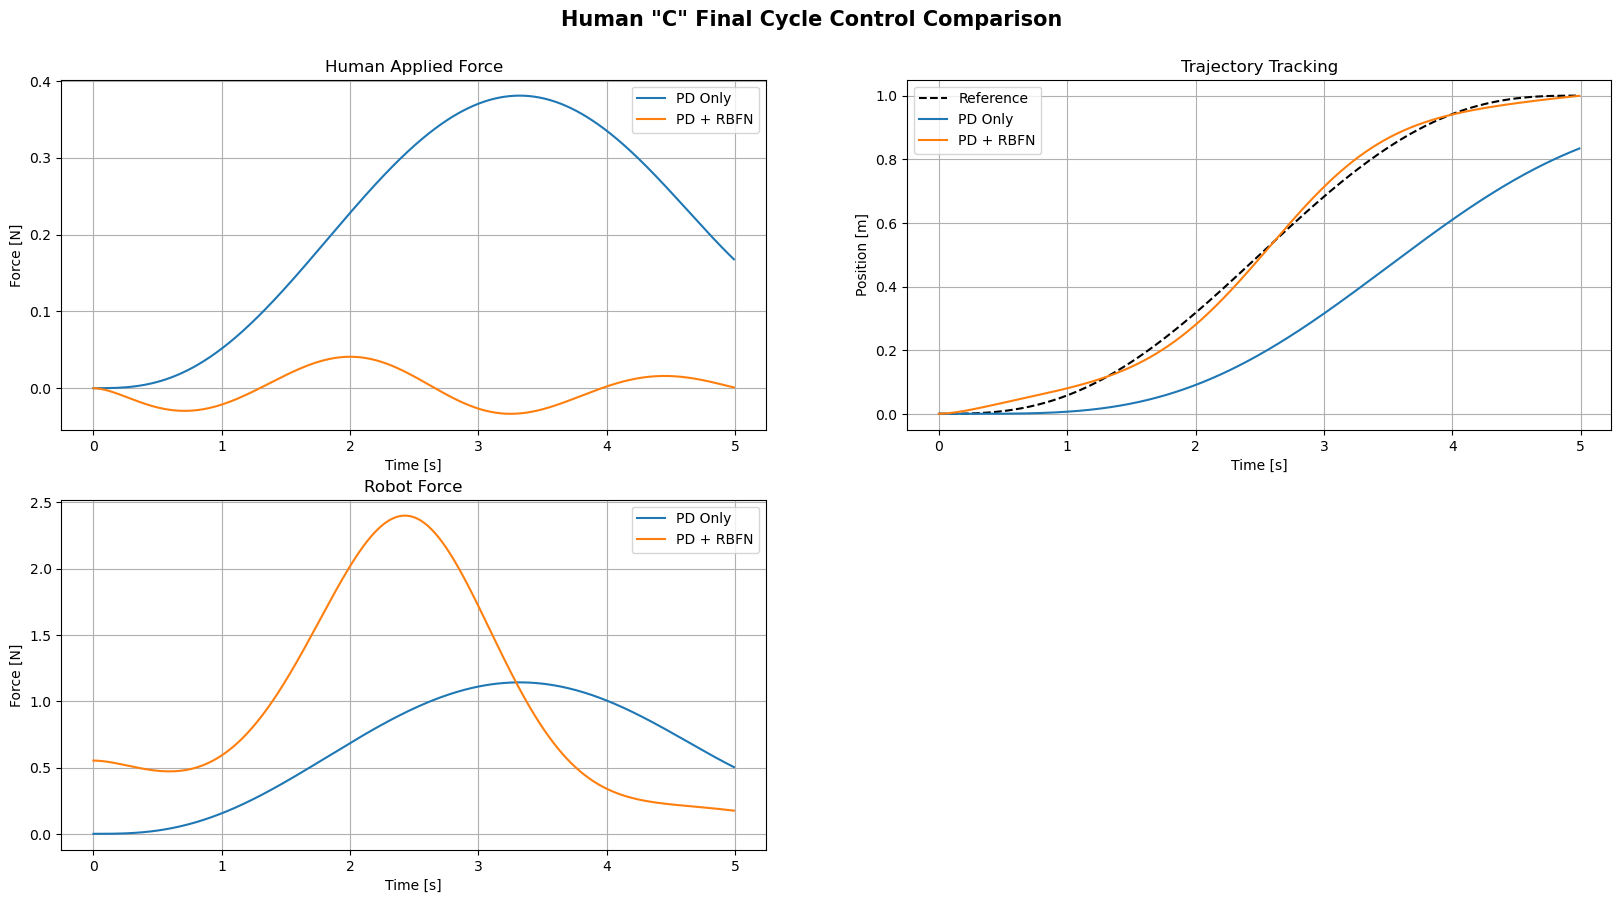

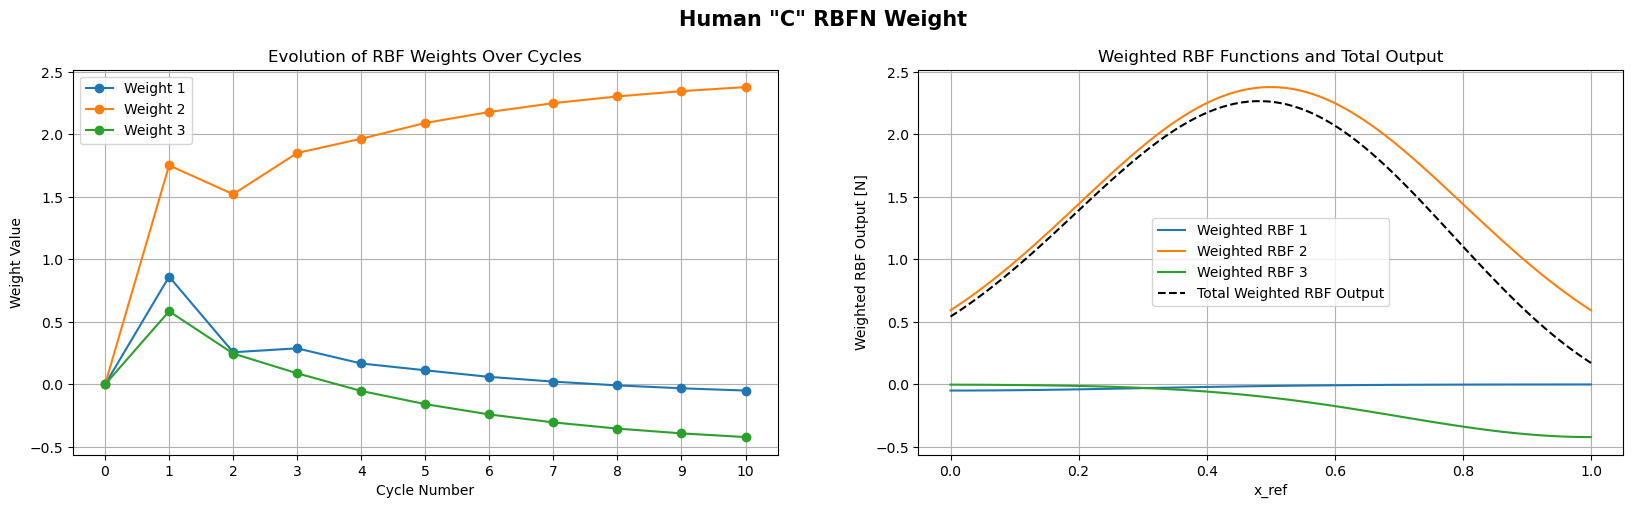

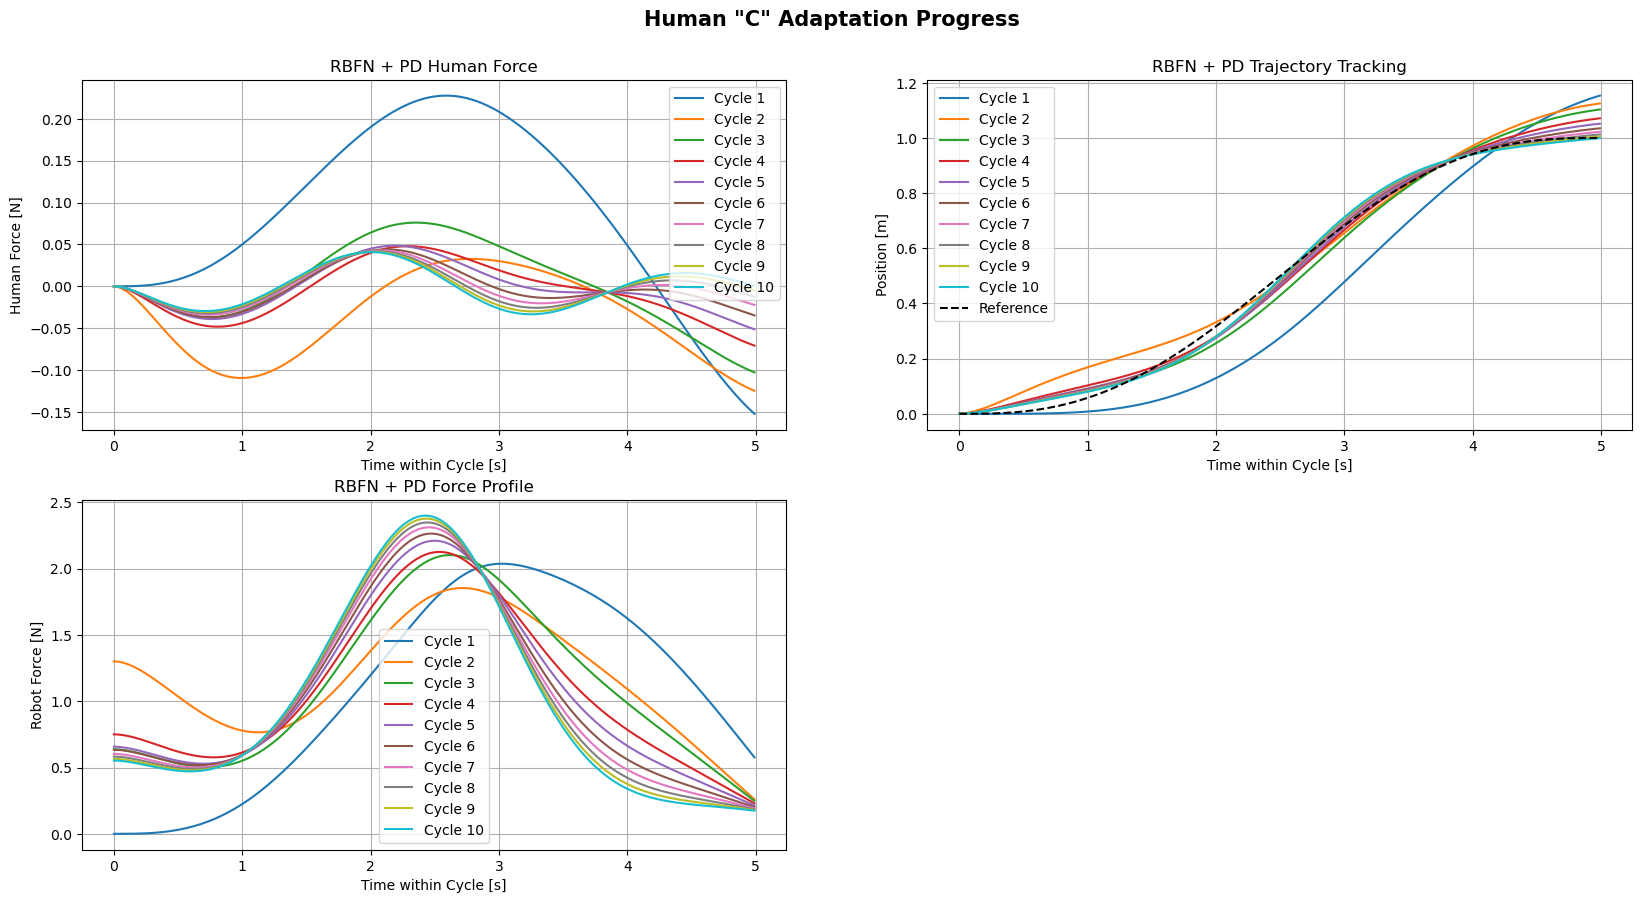

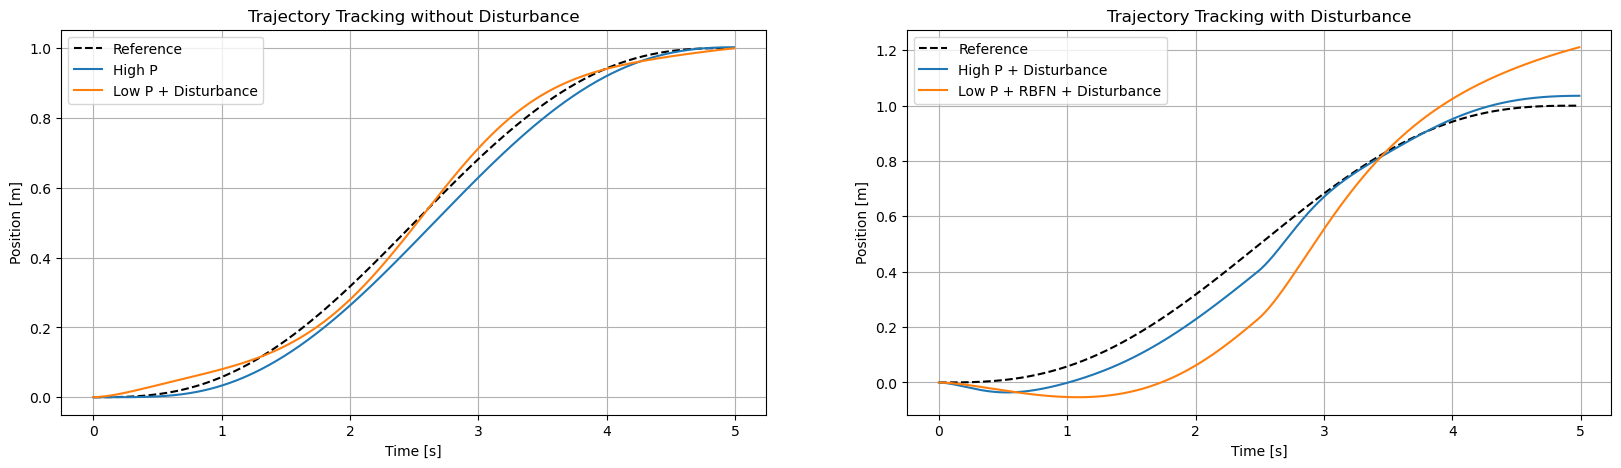

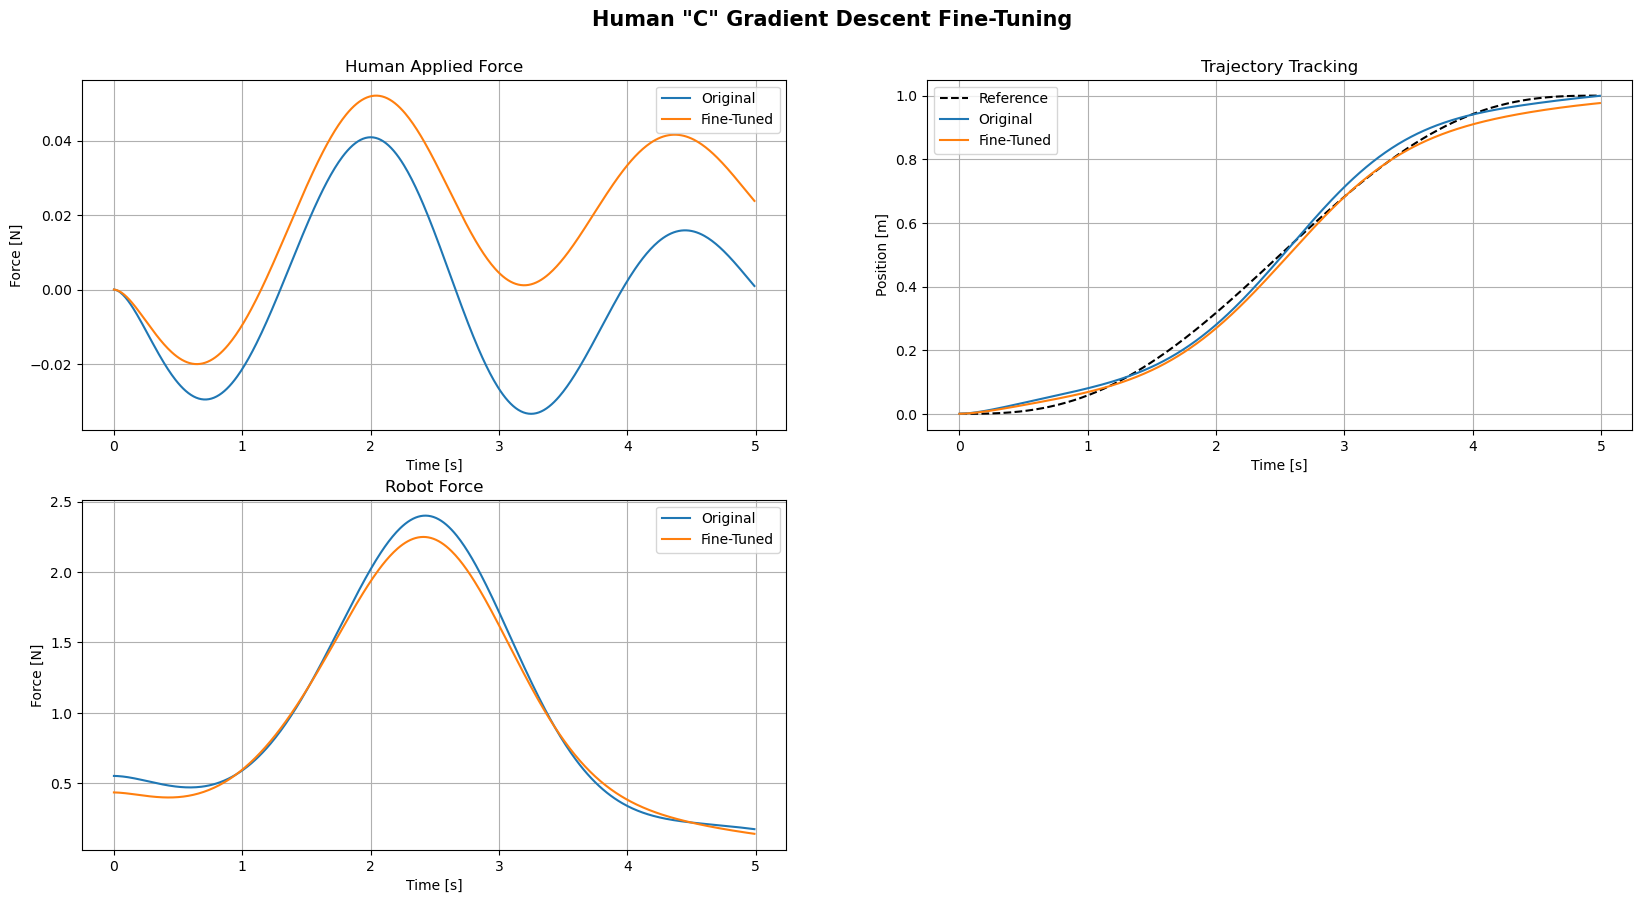

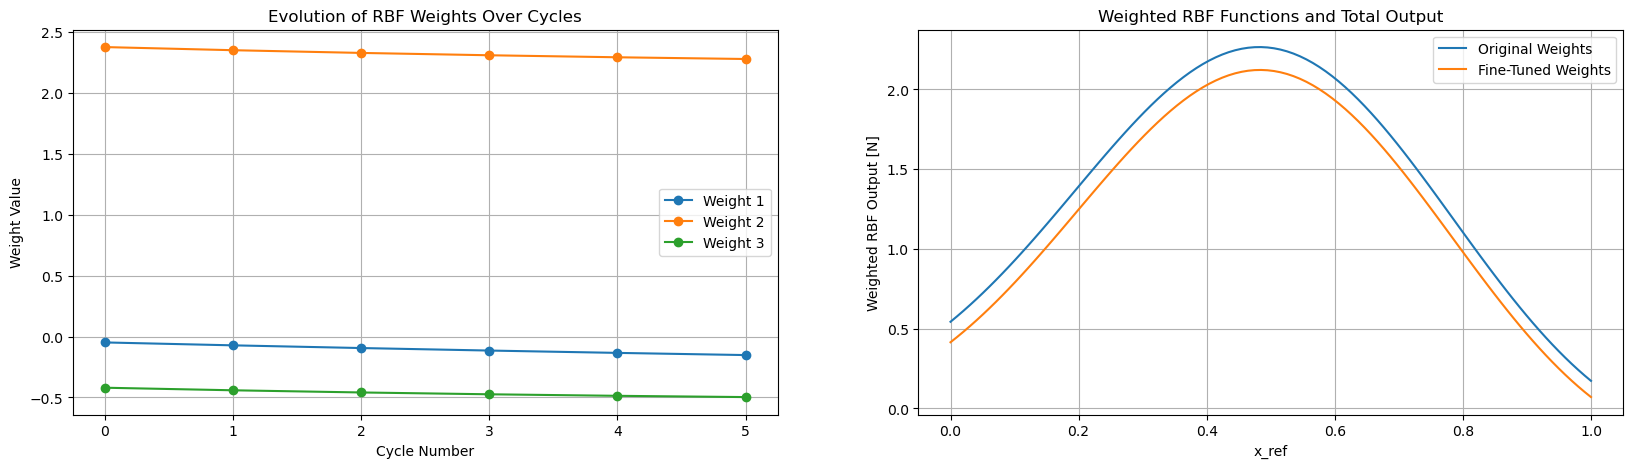

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

class MassDamperSystem:
    """
    1D mass-damper system with state [x, x_dot].
    """
    def __init__(self, m=1.0, b=5.0, x0=0.0, xdot0=0.0):
        self.m = m
        self.b = b
        self.x = x0
        self.xdot = xdot0

    def reset(self, x0=0.0, xdot0=0.0):
        self.x = x0
        self.xdot = xdot0

    def step(self, force, dt):
        xddot = (force - self.b * self.xdot) / self.m
        self.xdot += xddot * dt
        self.x += self.xdot * dt
        return self.x, self.xdot

class Controller:
    def compute_control(self, x, xdot, x_ref, dt):
        raise NotImplementedError("Subclass must implement compute_control()")

class PIDController(Controller):
    def __init__(self, Kp=3.0, Ki=0.0, Kd=0.0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.integral_error = 0.0
        self.prev_error = 0.0

    def compute_control(self, x, xdot, x_ref, dt):
        error = x_ref - x
        self.integral_error += error * dt
        d_error = (error - self.prev_error) / dt if dt > 0 else 0.0
        self.prev_error = error

        # PID control
        f_pid = self.Kp * error + self.Ki * self.integral_error + self.Kd * d_error
        return f_pid

class RBFController(Controller):
    def __init__(self, eta=6.0, n_rbf=3, centers=np.linspace(0, 1, 3), sigma=0.3, 
                forgetting_factor=1.0, initial_weights=None, train=True):
        """
        :param n_rbf: number of RBF units
        :param centers: array of RBF centers (if None, we'll set a default)
        :param sigma: RBF width
        :param eta: learning rate
        :param forgetting_factor: factor to scale old weights each update
        """
        self.n_rbf = n_rbf
        self.centers = centers
        self.sigma = sigma
        self.eta = eta
        self.forgetting_factor = forgetting_factor
        self.train = train

        if initial_weights is not None:
            self.weights = initial_weights.copy()
        else:
            self.weights = np.zeros(n_rbf)

    def compute_rbf_outputs(self, x_ref):
        """Compute Gaussian RBF outputs for a given reference x_ref."""
        return np.exp(-((x_ref - self.centers)**2) / (2 * self.sigma**2))

    def compute_control(self, x, xdot, x_ref, dt):
        """
        Returns the RBF 'assist' force and (optionally) updates the network's weights
        based on the tracking error (x_ref - x).
        """
        error = x_ref - x
        phi = self.compute_rbf_outputs(x_ref)
        f_rbfn = np.dot(self.weights, phi)

        # Only update weights if training is True
        if self.train:
            self.weights = self.forgetting_factor*self.weights + self.eta*error*phi*dt

        return f_rbfn
    
class Disturbance(Controller):
    def __init__(self, amplitude=2.0, switch_point=1.5):
        self.amplitude = amplitude
        self.switch_point = switch_point

    def compute_control(self, x, xdot, x_ref, dt):
        return -self.amplitude if x_ref < self.switch_point else self.amplitude
    
class GradientDescentController(Controller):
    """
    Gradient Descent Fine-Tuning Controller.
    
    This controller combines:
      - a PID controller (for the main control),
      - a fixed, pre-trained RBF "assist" term (with weights that are not updated here),
      - a set of "resist" weights that are updated online using gradient descent.
      
    The resist weights are updated using the gradient:
      grad_cost = (W1 - 2 * W2 * error * dt) * phi
    where:
      - phi are the RBF outputs,
      - error = (x_ref - x),
      - W1 and W2 are cost weights.
      
    The total control force output is:
        u_total = u_pid + f_assist
    (f_resist is computed and used to update the resist weights but not added to u_total,
     though you can modify this if desired.)
    """
    def __init__(self, assist_weights, centers, sigma, eta_resist, W1, W2, initial_resist_weights=None):
        """
        :param pid_controller: an instance of PIDController
        :param assist_weights: pre-trained assist weights (from an RBFController)
        :param centers: centers for the RBF units
        :param sigma: RBF width
        :param eta_resist: learning rate for updating resist weights
        :param W1: cost weight for the assist and resist forces
        :param W2: cost weight for the squared error term
        :param initial_resist_weights: (optional) initial resist weights; defaults to zeros.
        """
        self.assist_weights = assist_weights.copy()  # Fixed pre-trained assist weights
        self.centers = centers
        self.sigma = sigma
        self.eta_resist = eta_resist
        self.W1 = W1
        self.W2 = W2
        if initial_resist_weights is not None:
            self.resist_weights = initial_resist_weights.copy()
        else:
            self.resist_weights = np.zeros(len(centers))
        self.cost_history = []  # To log the cost over time if desired

    def compute_rbf_outputs(self, x_ref):
        """Compute Gaussian RBF outputs for a given reference x_ref."""
        return np.exp(-((x_ref - self.centers)**2) / (2 * self.sigma**2))

    def compute_control(self, x, xdot, x_ref, dt):
        error = x_ref - x
        # Compute RBF outputs
        phi = self.compute_rbf_outputs(x_ref)
        # Compute assist force using fixed pre-trained weights
        f_assist = np.dot(self.assist_weights, phi)
        f_resist = np.dot(self.resist_weights, phi)
        # Compute the combined cost (for monitoring purposes)
        cost = self.W1 * (f_assist + f_resist) + self.W2 * (error ** 2)
        self.cost_history.append(cost)
        # Compute gradient of cost with respect to the resist weights:
        grad_cost = (self.W1 - 2 * self.W2 * error * dt) * phi
        # Update resist weights via gradient descent
        self.resist_weights -= self.eta_resist * grad_cost
        u_total = f_assist + f_resist

        return u_total

class Simulator:
    def __init__(self, system, controllers, human_type="A"):
        """
        :param system: An instance of MassDamperSystem
        :param controllers: List of Controller instances (e.g., [PIDController, RBFController])
        :param human_type: Which human force profile to use
        """
        self.system = system
        self.controllers = controllers if isinstance(controllers, list) else [controllers]
        self.human_type = human_type

        self.all_cycle_sim = []
        self.all_cycle_robot = []
        self.all_cycle_human = []
        self.all_cycle_total = []
        self.all_cycle_weights = []

    def min_jerk_trajectory(self, duration, dt, x0, xf):
        time_vector = np.arange(0, duration, dt)
        tau = time_vector / duration
        x_ref_vector = x0 + (xf - x0) * (10 * tau**3 - 15 * tau**4 + 6 * tau**5)
        return time_vector, x_ref_vector

    def run(self, n_cycles, duration, dt, x0, xf):
        """
        Run multiple cycles of the simulation.
        """
        self.system.reset(x0, 0.0)
        time_vector, x_ref_vector = self.min_jerk_trajectory(duration, dt, x0, xf)

        for cycle in range(n_cycles):
            # Data storage
            x_sim_vector = []
            f_robot_vector = []
            f_human_vector = []
            f_total_vector = []
            error_vector = []

            self.system.reset(x0, 0.0)

            for i, t_current in enumerate(time_vector):
                x_ref = x_ref_vector[i]
                x, xdot = self.system.x, self.system.xdot
                error = x_ref - x

                # Compute total controller force as sum of all controllers
                f_robot = sum(controller.compute_control(x, xdot, x_ref, dt) for controller in self.controllers)
                f_human = get_human_force(t_current, x, x_ref, self.human_type)
                f_total = f_robot + f_human

                # Step the system
                x_next, xdot_next = self.system.step(f_total, dt)

                # Store data
                x_sim_vector.append(x_next)
                f_robot_vector.append(f_robot)
                f_human_vector.append(f_human)
                f_total_vector.append(f_total)
                error_vector.append(error)

            # Store per-cycle data
            self.all_cycle_sim.append(x_sim_vector)
            self.all_cycle_robot.append(f_robot_vector)
            self.all_cycle_human.append(f_human_vector)
            self.all_cycle_total.append(f_total_vector)
                        
            # Record RBF weights evolution if an RBF controller is present
            for controller in self.controllers:
                if isinstance(controller, RBFController):
                    self.all_cycle_weights.append(controller.weights.copy())
                    break
                elif isinstance(controller, GradientDescentController):
                    self.all_cycle_weights.append(controller.resist_weights.copy())
                    break

            print(f"[Simulator Progress] Cycle {cycle + 1}: Error MSE = {np.sum(np.array(error_vector)**2):.4f}")

def get_human_force(duration, x, x_ref, human_type="A"):
    """Compute human force (N) based on different profile types."""
    if human_type == "A":
        return 0.0
    elif human_type == "B":
        return 5.0
    elif human_type == "C":
        return 1.0 * (x_ref - x)
    elif human_type == "D":
        return 10.0 * (x_ref - x)
    elif human_type == "E":
        return 1.0 + 1.0 * np.sin(2 * np.pi * 0.3 * duration)
    return 0.0

def compute_rbf_outputs(x, centers, sigma):
        return np.exp(-((x - centers)**2) / (2 * sigma**2))

def main():
    # Simulation settings
    dt, duration = 0.01, 5.0  # seconds
    x0, xf, xdot0 = 0.0, 1.0, 0.0
    m, b = 1.0, 5.0
    n_rbf, centers, sigma = 3, np.linspace(x0, xf, 3), 0.3
    
    n_cycles = 10
    eta = 5
    human_type = "C"

    n_finetune_cycles = 5

    
    # ========== Simulation Setup ==========
    # Low P
    system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
    low_p_controller = PIDController(Kp=3.0, Ki=0.0, Kd=0.0)
    data_lp = Simulator(system, controllers=[low_p_controller], human_type=human_type)
    data_lp.run(n_cycles, duration, dt, x0, xf)

    # High P
    system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
    low_p_controller = PIDController(Kp=30.0, Ki=0.0, Kd=0.0)
    data_hp = Simulator(system, controllers=[low_p_controller], human_type=human_type)
    data_hp.run(n_cycles, duration, dt, x0, xf)

    # High P + Disturbance 
    system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
    high_p_controller = PIDController(Kp=30.0, Ki=0.0, Kd=0.0)
    disturbance = Disturbance(amplitude=1.0, switch_point=0.5)
    data_hp_dist = Simulator(system, controllers=[high_p_controller, disturbance], human_type="A")
    data_hp_dist.run(n_cycles, duration, dt, x0, xf)

    # Low P + RBFN (with online learing) 
    system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
    low_p_controller = PIDController(Kp=3.0, Ki=0.0, Kd=0.0)
    rbf_controller = RBFController(n_rbf=n_rbf, centers=centers, sigma=sigma, eta=eta, 
                                   forgetting_factor=1.0, train=True)
    data_lp_rbf = Simulator(system, controllers=[low_p_controller, rbf_controller], human_type=human_type)
    data_lp_rbf.run(n_cycles, duration, dt, x0, xf)

    weights_lp_rbf = data_lp_rbf.all_cycle_weights[-1]

    # Low P + RBFN (inference only) + Disturbance 
    system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
    low_p_controller = PIDController(Kp=3.0, Ki=0.0, Kd=0.0)
    rbf_controller = RBFController(n_rbf=n_rbf, centers=centers, sigma=sigma, eta=eta,
                                    forgetting_factor=1.0, initial_weights=weights_lp_rbf, train=False)
    disturbance = Disturbance(amplitude=1.0, switch_point=0.5)
    data_lp_rbf_dist = Simulator(system, controllers=[low_p_controller, rbf_controller, disturbance], human_type="A")
    data_lp_rbf_dist.run(n_cycles, duration, dt, x0, xf)

########## Low P + RBFN (inference only) + GD Fine Tuning -----
    system = MassDamperSystem(m=m, b=b, x0=x0, xdot0=xdot0)
    # Create a new PID controller for the GD controller (it can be separate from low_p_controller)
    pid_for_gd = PIDController(Kp=3.0, Ki=0.0, Kd=0.0)
    # Set gradient descent parameters (adjust these as needed)
    eta_resist = 0.1    # Learning rate for resist weights (set > 0 to see changes)
    W1 = 0.001           # Cost weight for total force
    W2 = 1.0            # Cost weight for the squared error term
    # Initialize the GradientDescentController with the pre-trained assist weights from the RBF training
    gd_controller = GradientDescentController(
        assist_weights=weights_lp_rbf,
        centers=centers,
        sigma=sigma,
        eta_resist=eta_resist,
        W1=W1,
        W2=W2
    )
    data_lp_rbf_gd = Simulator(system, controllers=[low_p_controller, gd_controller], human_type="C")
    data_lp_rbf_gd.run(n_finetune_cycles, duration, dt, x0, xf)
##########



    time_vector, x_ref_vector = data_lp.min_jerk_trajectory(duration, dt, x0, xf)

    # ========== Plot Final Cycle Comparison ==========
    plt.figure(figsize=(20, 10))
    plt.suptitle(f'Human "{human_type}" Final Cycle Control Comparison', fontsize=15, fontweight='bold', y=0.95)
    
    # 1. Human Force Comparison
    plt.subplot(2, 2, 1)
    plt.plot(time_vector, data_lp.all_cycle_human[-1], label='PD Only')
    plt.plot(time_vector, data_lp_rbf.all_cycle_human[-1], label='PD + RBFN')
    plt.xlabel('Time [s]')
    plt.ylabel('Force [N]')
    plt.title('Human Applied Force')
    plt.legend()
    plt.grid(True)
    
    # 2. Trajectory Tracking (PD + RBFN)
    plt.subplot(2, 2, 2)
    plt.plot(time_vector, x_ref_vector, 'k--', label='Reference')
    plt.plot(time_vector, data_lp.all_cycle_sim[-1], label='PD Only')
    plt.plot(time_vector, data_lp_rbf.all_cycle_sim[-1], label='PD + RBFN')
    plt.xlabel('Time [s]')
    plt.ylabel('Position [m]')
    plt.title('Trajectory Tracking')
    plt.legend()
    plt.grid(True)
    
    # 3. Robot Force Comparison
    plt.subplot(2, 2, 3)
    plt.plot(time_vector, data_lp.all_cycle_robot[-1], label='PD Only')
    plt.plot(time_vector, data_lp_rbf.all_cycle_robot[-1], label='PD + RBFN')
    plt.xlabel('Time [s]')
    plt.ylabel('Force [N]')
    plt.title('Robot Force')
    plt.legend()
    plt.grid(True)
    
    # ========== Plot RBF Weights ==========
    plt.figure(figsize=(20, 5))
    plt.suptitle(f'Human "{human_type}" RBFN Weight', fontweight="bold", fontsize=15, y=1.0)
    
    # 1. Evolution of RBF Weights Over Cycles
    plt.subplot(1, 2, 1)
    all_cycle_weights_from_zero = np.vstack((np.zeros(n_rbf), np.array(data_lp_rbf.all_cycle_weights)))  # Include cycle 0 (assumed zero weights)
    for i in range(n_rbf):
        plt.plot(range(n_cycles+1), all_cycle_weights_from_zero[:, i], marker='o', label=f'Weight {i+1}')
    plt.xlabel('Cycle Number')
    plt.ylabel('Weight Value')
    plt.title('Evolution of RBF Weights Over Cycles')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(n_cycles+1))
    
    # 2. Weighted RBF Functions and Total Output
    x_range = np.linspace(0, 1, 100)
    phi_matrix = np.zeros((len(x_range), n_rbf))
    for i, x_val in enumerate(x_range):
        phi_matrix[i, :] = compute_rbf_outputs(x_val, centers, sigma)
    weighted_phi_matrix = phi_matrix * data_lp_rbf.all_cycle_weights[-1]  # using last cycle weights
    weighted_total = np.sum(weighted_phi_matrix, axis=1)
    
    plt.subplot(1, 2, 2)
    for i in range(n_rbf):
        plt.plot(x_range, weighted_phi_matrix[:, i], label=f'Weighted RBF {i+1}')
    plt.plot(x_range, weighted_total, 'k--', label='Total Weighted RBF Output')
    plt.xlabel('x_ref')
    plt.ylabel('Weighted RBF Output [N]')
    plt.title('Weighted RBF Functions and Total Output')
    plt.legend()
    plt.grid(True)
    
    # ========== Plot All Cycles (PD + RBFN) ==========
    plt.figure(figsize=(20, 10))
    plt.suptitle(f'Human "{human_type}" Adaptation Progress', fontweight="bold", fontsize=15, y=0.95)
    
    # 1. Human Force per Cycle
    plt.subplot(2, 2, 1)
    for idx, hf in enumerate(data_lp_rbf.all_cycle_human):
        plt.plot(time_vector, hf, label=f'Cycle {idx+1}')
    plt.xlabel('Time within Cycle [s]')
    plt.ylabel('Human Force [N]')
    plt.title('RBFN + PD Human Force')
    plt.legend()
    plt.grid(True)
    
    # 2. Trajectory Tracking per Cycle
    plt.subplot(2, 2, 2)
    for idx, traj in enumerate(data_lp_rbf.all_cycle_sim):
        plt.plot(time_vector, traj, label=f'Cycle {idx+1}')
    plt.plot(time_vector, x_ref_vector, 'k--', label='Reference')
    plt.xlabel('Time within Cycle [s]')
    plt.ylabel('Position [m]')
    plt.title('RBFN + PD Trajectory Tracking')
    plt.legend()
    plt.grid(True)
    
    # 3. Total Robot Force (PD + RBFN) per Cycle
    plt.subplot(2, 2, 3)
    for idx, rf in enumerate(data_lp_rbf.all_cycle_robot):
        plt.plot(time_vector, rf, label=f'Cycle {idx+1}')
    plt.xlabel('Time within Cycle [s]')
    plt.ylabel('Robot Force [N]')
    plt.title('RBFN + PD Force Profile')
    plt.legend()
    plt.grid(True)

    # ========== Compliance Comparison ==========
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(time_vector, x_ref_vector, 'k--', label='Reference')
    plt.plot(time_vector, data_hp.all_cycle_sim[-1], label='High P')
    plt.plot(time_vector, data_lp_rbf.all_cycle_sim[-1], label='Low P + Disturbance')
    plt.xlabel('Time [s]')
    plt.ylabel('Position [m]')
    plt.title('Trajectory Tracking without Disturbance')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(time_vector, x_ref_vector, 'k--', label='Reference')
    plt.plot(time_vector, data_hp_dist.all_cycle_sim[-1], label='High P + Disturbance')
    plt.plot(time_vector, data_lp_rbf_dist.all_cycle_sim[-1], label='Low P + RBFN + Disturbance')
    plt.xlabel('Time [s]')
    plt.ylabel('Position [m]')
    plt.title('Trajectory Tracking with Disturbance')
    plt.legend()
    plt.grid(True)
    
    plt.show()

    # ========== Gradient Descent Fine-Tuning ==========
    plt.figure(figsize=(20, 10))
    plt.suptitle(f'Human "{human_type}" Gradient Descent Fine-Tuning', fontweight="bold", fontsize=15, y=0.95)

    # 1. Human Force Comparison
    plt.subplot(2, 2, 1)
    plt.plot(time_vector, data_lp_rbf.all_cycle_human[-1], label='Original')
    plt.plot(time_vector, data_lp_rbf_gd.all_cycle_human[-1], label='Fine-Tuned')
    plt.xlabel('Time [s]')
    plt.ylabel('Force [N]')
    plt.title('Human Applied Force')
    plt.legend()
    plt.grid(True)

    # 2. Trajectory Tracking
    plt.subplot(2, 2, 2)
    plt.plot(time_vector, x_ref_vector, 'k--', label='Reference')
    plt.plot(time_vector, data_lp_rbf.all_cycle_sim[-1], label='Original')
    plt.plot(time_vector, data_lp_rbf_gd.all_cycle_sim[-1], label='Fine-Tuned')
    plt.xlabel('Time [s]')
    plt.ylabel('Position [m]')
    plt.title('Trajectory Tracking')
    plt.legend()
    plt.grid(True)

    # 3. Robot Force Comparison
    plt.subplot(2, 2, 3)
    plt.plot(time_vector, data_lp_rbf.all_cycle_robot[-1], label='Original')
    plt.plot(time_vector, data_lp_rbf_gd.all_cycle_robot[-1], label='Fine-Tuned')
    plt.xlabel('Time [s]')
    plt.ylabel('Force [N]')
    plt.title('Robot Force')
    plt.legend()
    plt.grid(True)

    
    # 1. Evolution of RBF Weights Over Cycles
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 2, 1)
    x_range = range(n_finetune_cycles+1)
    fine_tuned_weights = np.array([data_lp_rbf.all_cycle_weights[-1]]) + np.array(data_lp_rbf_gd.all_cycle_weights)
    fine_tunend_weights_from_origin = np.vstack([data_lp_rbf.all_cycle_weights[-1], fine_tuned_weights])
    
    # fine_tuned_weights = np.array([data_lp_rbf.all_cycle_weights[-1]] + data_lp_rbf_gd.all_cycle_weights)
    for i in range(n_rbf):
        plt.plot(x_range, fine_tunend_weights_from_origin[:, i], marker='o', label=f'Weight {i+1}')
    plt.xlabel('Cycle Number')
    plt.ylabel('Weight Value')
    plt.title('Evolution of RBF Weights Over Cycles')
    plt.legend()
    plt.grid(True)

    # 2. Total Weighted RBF Functions and Total Output
 
    x_range = np.linspace(0, 1, 100)
    phi_matrix = np.zeros((len(x_range), n_rbf))
    for i, x_val in enumerate(x_range):
        phi_matrix[i, :] = compute_rbf_outputs(x_val, centers, sigma)


    weighted_phi_matrix_original = np.sum(phi_matrix * data_lp_rbf.all_cycle_weights[-1], axis=1)
    weighted_phi_matrix_fine_tuned = np.sum(phi_matrix * fine_tunend_weights_from_origin[-1], axis=1)



    plt.subplot(1, 2, 2)
    plt.plot(x_range, weighted_phi_matrix_original, label='Original Weights')
    plt.plot(x_range, weighted_phi_matrix_fine_tuned, label='Fine-Tuned Weights')
    plt.xlabel('x_ref')
    plt.ylabel('Weighted RBF Output [N]')
    plt.title('Weighted RBF Functions and Total Output')
    plt.legend()
    plt.grid(True)
    
    plt.show()





if __name__ == "__main__":
    main()

In [23]:
# fine_tuned_weights = np.array(data_lp_rbf.all_cycle_weights[-1]) + np.array(data_lp_rbf_gd.all_cycle_weights)
print(data_lp_rbf.all_cycle_weights[-1])

NameError: name 'data_lp_rbf' is not defined